# Prepare online pipelines offline

In [1]:
import matplotlib.pyplot as plt 
from moabb.datasets import SSVEPExo
from moabb.paradigms import SSVEP
import numpy as np
import pandas as pd 
from pyriemann.classification import MDM
from pyriemann.clustering import Potato
from scipy.stats import norm
import seaborn as sns 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from utils.epochs import extract_epochs
from utils.estimation import SSVEPCovariance, SSVEPPotato

## Read MOABB paradigm and data

In [2]:
paradigm = SSVEP(n_classes=4)
dataset = SSVEPExo()
data = dataset.get_data()
subjects = dataset.subject_list
N = len(subjects)
print(f'Found {N} subjects')
print(f'Found {set([len(data[subject]) for subject in subjects])} sessions per subjects')
print(f'Found {set([len(data[subject]["session_0"]) for subject in subjects])} runs per session')

raw = data[12]['session_0']['run_1']
# check we have all classes we expected
_classes = set()
for subject in subjects:
    for session in data[subject].keys():
        for run in data[subject][session].keys():
            raw = data[subject][session][run]
            X, y, _ = paradigm.process_raw(raw, dataset)
            _classes = set(list(_classes) + list(set(y)))
print(f'Found class {_classes}')

Choosing the first 4 classes from all possible events


Found 12 subjects
Found {1} sessions per subjects
Found {2, 3, 4, 5} runs per session
Found class {'17', '13', 'rest', '21'}


## Epoch data: train, test

In [3]:
# cv split  
run_train = 'run_0'
run_test = 'run_1'

# epoch onset/offset
tmin = 1
tmax = 7

# for 4 classes 
event_id = {'rest': 1, '13': 2, '17': 3, '21': 4}
def get_epoched_data(subjects, tmin=tmin, tmax=tmax, event_id=event_id):
    epoched_data = {}
    for subject in subjects: 
        Xtrain, ytrain = extract_epochs(data[subject]["session_0"][run_train], event_id=event_id, tmin=tmin, tmax=tmax)
        Xtest, ytest = extract_epochs(data[subject]["session_0"][run_test], event_id=event_id, tmin=tmin, tmax=tmax)
        epoched_data[subject] = {'train': (Xtrain, ytrain), 'test':(Xtest, ytest)}
    return epoched_data
epoched_data = get_epoched_data(subjects, tmin=tmin, tmax=tmax, event_id=event_id)

## Classification: SSVEPCovariance + MDM 

In [4]:
fs = 256
# parameters from SSVEPCovariance
flickering_frequencies = (13, 17, 21)
bandwidth = 4
order = 2
filter_design = 'iir'
padlen = None

clf = make_pipeline(SSVEPCovariance(fs, flickering_frequencies,'scm', padlen= padlen, bandwidth=bandwidth, order=order), MDM())

acc_scores_4classes = []
for subject in subjects: 
    Xtrain, ytrain = epoched_data[subject]['train']
    Xtest, ytest = epoched_data[subject]['test']
    clf.fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)
    acc_scores_4classes.append(accuracy_score(ypred, ytest))
df = pd.DataFrame(acc_scores_4classes, columns=['accuracy'], index=subjects).reset_index().rename({'index':'subjects'}, axis=1)

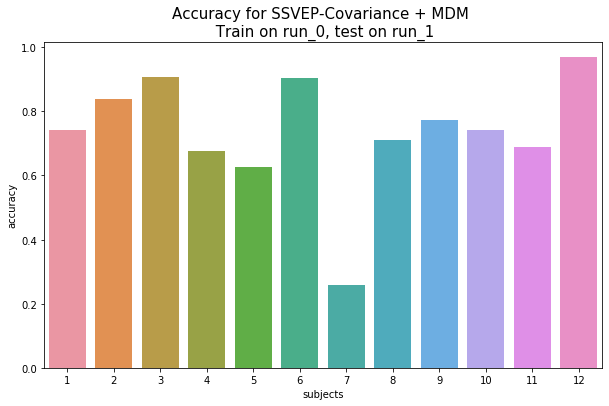

In [5]:
plt.figure(figsize=(10, 6))
sns.barplot(x="subjects", y="accuracy", data=df)
plt.title('Accuracy for SSVEP-Covariance + MDM \n Train on run_0, test on run_1', fontsize=15)
plt.show()

### Parameter optimisation with grid search 

In [6]:
# parameters of epoching
list_tmax = [4, 5, 6] 
# parameters from SSVEPCovariance
fs = 256
flickering_frequencies = (13, 17, 21)
list_bandwidth = [1, 2, 3, 4]
list_order = [2, 4, 6, 8]
filter_design = 'iir'
padlen = None



subjects = data.keys()
event_id = {'rest': 1, '13': 2, '17': 3, '21': 4}

scores = []

for order in list_order:
    for bandwidth in list_bandwidth:          
        # for each combination of parameters, train pipeeline
        clf = make_pipeline(SSVEPCovariance(fs, flickering_frequencies,'lwf', padlen= padlen, bandwidth=bandwidth, order=order), MDM())
        for tmax in list_tmax:
            epoched_data = get_epoched_data(subjects, tmax=tmax, event_id=event_id)
            for subject in epoched_data.keys():
                    Xtrain, ytrain = epoched_data[subject]['train']
                    Xtest, ytest = epoched_data[subject]['test']
                    ypred = clf.fit(Xtrain, ytrain).predict(Xtest)
                    score = accuracy_score(ytest, ypred)
                    # if we got a better score, store the score and parametersab
                    scores.append({'subject': subject, 'order': order, 'tmax': tmax , 'bandwidth': bandwidth, 'score': score})  


Best params are order 2, bandwidth 1 and tmax 6


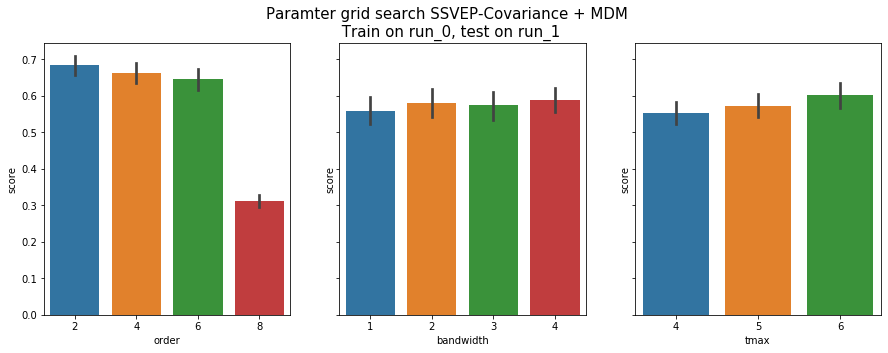

In [7]:
df = pd.DataFrame(scores)

f, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
for k_var, variable in enumerate(['order', 'bandwidth', 'tmax']):
    df_melt = df[[variable, 'score', 'subject']].melt(['score', 'subject'], value_name=variable)
    sns.barplot(data=df_melt, x=variable, y='score', ax=ax[k_var])
plt.suptitle('Paramter grid search SSVEP-Covariance + MDM \n Train on run_0, test on run_1', fontsize=15)

best_order, best_bandwidth, best_tmax =  df.groupby(['order', 'bandwidth', 'tmax'])['score'].mean().idxmax()
print(f'Best params are order {best_order}, bandwidth {best_bandwidth} and tmax {best_tmax}')